In [1]:
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import csv

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2
%matplotlib inline

from helpers import calculate_mse

# 0.1 Load and prepare data

### Training and testing data

#### Load the Data
`ratings` is a sparse matrix in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

DATA_PATH = '../data/'
PREDICTION_PATH = '../data/predictions/'
#ratings = load_data('{dp}data_train.csv'.format(dp=DATA_PATH))
ratings = load_data('{dp}movielens100k.csv'.format(dp=DATA_PATH))

number of items: 1682, number of users: 943


#### Plot the number of ratings per movie and user

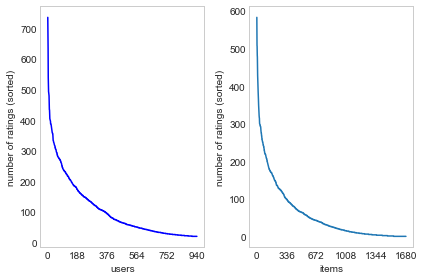

min # of items per user = 20, min # of users per item = 1.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

#### Split the data into a train and test set

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1, verbose=False):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][:, valid_users]
    
    # LIL is a convenient format for constructing sparse matrices
    train = sp.lil_matrix(valid_ratings.shape)
    test = sp.lil_matrix(valid_ratings.shape)
    
    valid_ratings_i, valid_ratings_u, valid_ratings_v = sp.find(valid_ratings)
    valid_ratings_p_idx = np.random.permutation(range(len(valid_ratings_i)))
    
    n_test = int(p_test*len(valid_ratings_i))
    
    for idx in valid_ratings_p_idx[:n_test]:
        test[valid_ratings_i[idx], valid_ratings_u[idx]] = valid_ratings_v[idx]
        
    for idx in valid_ratings_p_idx[n_test:]:
        train[valid_ratings_i[idx], valid_ratings_u[idx]] = valid_ratings_v[idx]

    if verbose:
        print("Total number of nonzero elements in original data:{v}".format(v=ratings.nnz))
        print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
        print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    
    # convert to CSR for faster operations
    return valid_ratings, train.tocsr(), test.tocsr()

In [5]:
valid_ratings, train, test = split_data(ratings, num_items_per_user,
    num_users_per_item, min_num_ratings=10, p_test=0.1, verbose=True)

Total number of nonzero elements in original data:99999
Total number of nonzero elements in train data:88157
Total number of nonzero elements in test data:9795


### Read submission creation data

In [6]:
ratings_csr = ratings.tocsr()
sample_submission = load_data('{dp}sample_submission.csv'.format(dp=DATA_PATH))
sample_submission_csr = sample_submission.tocsr()

number of items: 10000, number of users: 1000


# 0.2 Auxiliary functions

In [7]:
def compute_division(a, b):
    """Computes element by element division.
    If x/0 returns 0.
    """
    # Raises error if vectors have different lengths
    assert(len(a) == len(b))
    
    # Computes division
    res = a.copy()
    for i in range(len(a)):
        if b[i] == 0:
            res[i] = 0
        else:
            res[i] = a[i] / b[i]

    return res

# 1 Baselines

In [8]:
# Baseline rating
def baseline_rating(data):
    """Implements baseline method for a ratings matrix
    using the global mean.
    """
    # Compute global mean using training data
    r_mean = data.sum() / data.getnnz()
    
    return r_mean


# User or item specific effect
def baseline_user_item_specific(data, mean, set_num=0):
    """Implements baseline method for a ratings matrix
    using either the user or the item mean,
    as indicated in parameter mean.
    """
    if mean=="user":
        flag = 1
        inv_flag = 0
    else:
        flag = 0
        inv_flag = 1

    num = max(set_num, data.shape[flag])
    
    # Obtain r_demeaned (ratings minus global avg)
    global_mean = baseline_rating(data)
    r_demeaned = data.copy()
    r_demeaned.data = (1.0 * r_demeaned.data) - global_mean
    
    # Compute means using training data
    # get rows, columns and values for elements in r_demeaned
    data_rcv = sp.find(r_demeaned)
    # compute means
    counts = np.bincount(data_rcv[flag], minlength=num)
    sums = np.bincount(data_rcv[flag], weights=data_rcv[2], minlength=num)
    means = compute_division(sums, counts)

    return means

In [9]:
def demean_matrix(data, verbose=False):
    """Removes the global, user and item means from a matrix.
    Returns the matrix and the computed means.
    """
    num_items, num_users = data.shape
    (rows, cols, vals) = sp.find(data)
    
    # Compute global, user and item means    
    global_mean = baseline_rating(data)
    item_means = baseline_user_item_specific(data, 'item')
    user_means = baseline_user_item_specific(data, 'user')
    
    # Substract the baseline of each element in 'data'
    train_vals = vals.copy()
    train_vals = 1.0 * train_vals
    
    baselines = np.array([(global_mean + item_means[i] + user_means[u])
        for (i, u) in zip(rows, cols)])
    train_vals -= baselines

    # Get matrix
    r_demeaned = sp.csr_matrix((train_vals, (rows, cols)),
        shape=(num_items, num_users))
    
    if verbose:
        print('---------------------------------------------')
        print('          Completed demean_matrix!           ')
        print('---------------------------------------------')
    
    return r_demeaned, global_mean, user_means, item_means

In [10]:
def demean_test_matrix(data, global_mean, item_means, user_means,
    verbose=False):
    """Removes the global, user and item means from a matrix.
    Returns the matrix and the computed means.
    """
    num_items, num_users = data.shape
    (rows, cols, vals) = sp.find(data)
    
    # Substract the baseline of each element in 'data'
    train_vals = vals.copy()
    train_vals = 1.0 * train_vals
    
    baselines = np.array([(global_mean + item_means[i] + user_means[u])
        for (i, u) in zip(rows, cols)])
    train_vals -= baselines

    # Get matrix
    r_demeaned = sp.csr_matrix((train_vals, (rows, cols)),
        shape=(num_items, num_users))
    
    if verbose:
        print('---------------------------------------------')
        print('          Completed demean_matrix!           ')
        print('---------------------------------------------')
    return r_demeaned

# 2 Matrix Factorization

In [11]:
def init_MF(data, k):
    """Initializes parameters for Matrix Factorization.
    Assumes 'data' matrix is already demeaned.
    """      
    np.random.seed(988)
    num_items, num_users = data.shape
    u_features = np.random.rand(num_users, k)
    i_features = np.random.rand(num_items, k)
    return u_features, i_features

Compute the cost by the method of matrix factorization.

In [12]:
def compute_error(data, u_features, i_features, nz):
    """Compute RMSE for prediction of nonzero elements."""
    preds = np.array([(u_features[u,:].dot(i_features[i,:]))
        for (i, u) in nz])
    vals = np.array([data[i,u] for (i,u) in nz])
    mse = calculate_mse(vals, preds)  
    rmse = np.sqrt(mse / len(vals))
    return rmse

In [41]:
def compute_mf_SGD(r_demeaned, nz_train, test_r_demeaned, nz_test, k=20, gamma=0.01, gamma_dec=1.2,
    u_lambda=0.5, i_lambda=0.5, max_iter=None, int_vals=False, verbose=False, tol=1e-5,
    init_u_features=None, init_i_features=None):
    """Compute matrix factorization by SGD.
    Both 'data' and 'test_data' should be csr sparse matrices.
    gamma_dec should be >=1
    """

    #assert k <= min(data.shape), "k must be smaller than the min dimension of 'data'"
    if (max_iter is None):
        steps = 50
    else:
        steps = max_iter

    # Set seed
    np.random.seed(988)
    
    rand_u_features, rand_i_features = init_MF(r_demeaned, k)
    
    if (init_u_features is None):
        u_features = rand_u_features
    else:
        u_features = init_u_features
        
    if (init_i_features is None):
        i_features = rand_i_features
    else:
        i_features = init_i_features
    
    if verbose:
        print("Starting matrix factorization with SGD...")

    rmse = 0
    for step in range(steps):
        # shuffle the training rating indices
        np.random.seed(988)
        np.random.shuffle(nz_train)
        
        # Reduce learning rate
        gamma /= gamma_dec
        
        # Update item and user features
        for i, u in nz_train:
            i_f = i_features[i,:]
            u_f = u_features[u,:]
            e = r_demeaned[i, u] - np.dot(u_f,i_f)
            # Obtain gradient
            i_grad = e * u_f - i_lambda * i_f
            u_grad = e * i_f - u_lambda * u_f
            # Update user and item features
            i_features[i,:] += gamma * i_grad
            u_features[u,:] += gamma * u_grad
        
        rmse_old = rmse
        rmse = compute_error(r_demeaned, u_features, i_features, nz_train)
        print("{} - train_RMSE: {}.".format(step, rmse))

        # evaluate the test error
        test_rmse = compute_error(test_r_demeaned, u_features, i_features, nz_test)
        print("test RMSE: {}.".format(test_rmse))
        
        if(rmse_old - rmse < 0):
            gamma_dec += .15
            gamma /= gamma_dec
        elif(abs(rmse_old - rmse) <= tol):
            break

    return i_features, u_features, rmse

### Try different parameters

In [35]:
# Demean matrix and get feature vectors
r_demeaned, global_mean, user_means, item_means = demean_matrix(train, verbose=False)

# Get non-zero elements
nz_row, nz_col = train.nonzero()
nz_train = list(zip(nz_row, nz_col))

test_r_demeaned = demean_test_matrix(test, global_mean, item_means,
    user_means, verbose=False)
nz_row, nz_col = test.nonzero()
nz_test = list(zip(nz_row, nz_col))

In [ ]:
results_k = {}
i=0
for k in range(10, 110, 10):
    print('----------------------------')
    print('       k={}                    '.format(k))
    print('----------------------------')
    i_features, u_features, rmse = compute_mf_SGD(r_demeaned, nz_train, test_r_demeaned, nz_test, k=k, int_vals=True, verbose=True)
    results_k[i]=(k, i_features, u_features, rmse)
    i += 1

In [ ]:
results_gamma = {}
i=0
for gamma in np.logspace(-3, -1, 10):
    print('----------------------------')
    print('       gamma={}                    '.format(gamma))
    print('----------------------------')
    i_features, u_features, rmse = compute_mf_SGD(r_demeaned, nz_train, test_r_demeaned, nz_test, gamma=gamma, int_vals=True, verbose=True)
    results_gamma[i]=(gamma, i_features, u_features, rmse)
    i+=1

In [ ]:
np.random.seed(988)
results_u_lambda = {}
i=0
for u_lambda in np.linspace(0,2,10):
    print('----------------------------')
    print('       u_lambda={}                    '.format(u_lambda))
    print('----------------------------')
    i_features, u_features, rmse = compute_mf_SGD(r_demeaned, nz_train, test_r_demeaned, nz_test, u_lambda=u_lambda, int_vals=True, verbose=True)
    results_u_lambda[i]=(u_lambda, i_features, u_features, rmse)
    i+=1

In [ ]:
results_i_lambda = {}
i=0
i_features=None
u_features=None
for i_lambda in np.linspace(0,2,10):
    print('----------------------------')
    print('       i_lambda={}                    '.format(i_lambda))
    print('----------------------------')
    i_features, u_features, rmse = compute_mf_SGD(r_demeaned, nz_train, test_r_demeaned,
        nz_test, i_lambda=i_lambda, int_vals=True, verbose=True, init_i_features=i_features,
        init_u_features=u_features)
    results_i_lambda[i]=(i_lambda, i_features, u_features, rmse)
    i+=1

In [58]:
i_features, u_features, rmse = compute_mf_SGD(r_demeaned, nz_train, test_r_demeaned,
    nz_test, i_lambda=0, u_lambda=0, int_vals=True, verbose=True,
    init_i_features=i_features, init_u_features=u_features)

Starting matrix factorization with SGD...
0 - train_RMSE: 0.9319571454308242.
test RMSE: 0.9665100526794229.
1 - train_RMSE: 0.9312761003886793.
test RMSE: 0.96638297428526.
2 - train_RMSE: 0.9307966970701645.
test RMSE: 0.9663056551165.
3 - train_RMSE: 0.930444498826798.
test RMSE: 0.9662435940744988.
4 - train_RMSE: 0.9301826426210329.
test RMSE: 0.9661981024687464.
5 - train_RMSE: 0.9299872733334507.
test RMSE: 0.9661662901972351.
6 - train_RMSE: 0.9298414342627287.
test RMSE: 0.966142948024491.
7 - train_RMSE: 0.9297326509507978.
test RMSE: 0.96612425520987.
8 - train_RMSE: 0.9296515963453335.
test RMSE: 0.9661100084477544.
9 - train_RMSE: 0.9295912796492761.
test RMSE: 0.9660996463479206.


KeyboardInterrupt: 

In [61]:
i_features, u_features, rmse = compute_mf_SGD(r_demeaned, nz_train, test_r_demeaned,
    nz_test, i_lambda=0.2, u_lambda=2.0, int_vals=True, verbose=True,
    gamma=.01, gamma_dec=1.2,
    init_i_features=i_features, init_u_features=u_features)

Starting matrix factorization with SGD...
0 - train_RMSE: 0.9340167954020437.
test RMSE: 0.9669795994027292.
1 - train_RMSE: 0.9340276008467745.
test RMSE: 0.9669488820057074.


KeyboardInterrupt: 

In [67]:
i_features, u_features, rmse = compute_mf_SGD(r_demeaned, nz_train, test_r_demeaned,
    nz_test, i_lambda=0.2, u_lambda=2.0, int_vals=True, verbose=True,
    gamma=.3, gamma_dec=1.9,
    init_i_features=i_features, init_u_features=u_features)

Starting matrix factorization with SGD...
0 - train_RMSE: 0.9343196766290522.
test RMSE: 0.967031068535483.
1 - train_RMSE: 0.9343195637013358.
test RMSE: 0.9670315909074707.


In [ ]:
i_features, u_features, rmse = compute_mf_SGD(r_demeaned, nz_train, test_r_demeaned,
    nz_test, i_lambda=0.4, u_lambda=2.0, int_vals=True, verbose=True,
    init_i_features=i_features, init_u_features=u_features)

In [ ]:
i_features, u_features, rmse = compute_mf_SGD(r_demeaned, nz_train, test_r_demeaned,
    nz_test, i_lambda=0.6, u_lambda=2.0, int_vals=True, verbose=True,
    init_i_features=i_features, init_u_features=u_features)

### Generate a submission file

In [ ]:
# Demean matrix and get feature vectors
r_demeaned, global_mean, user_means, item_means = demean_matrix(ratings_csr, verbose=False)

# Get non-zero elements
nz_row, nz_col = ratings_csr.nonzero()
nz_train = list(zip(nz_row, nz_col))

In [ ]:
def compute_mf_SGD(r_demeaned, nz_train, k=20, gamma=0.01, gamma_dec=1.2,
    u_lambda=0.5, i_lambda=0.5, max_iter=None, int_vals=False, verbose=False, tol=1e-6):
    """Compute matrix factorization by SGD.
    'data' should be a csr sparse matrices.
    gamma_dec should be >=1
    """

    #assert k <= min(data.shape), "k must be smaller than the min dimension of 'data'"
    if (max_iter is None):
        steps = 50
    else:
        steps = max_iter

    # Set seed
    np.random.seed(988)

    u_features, i_features = init_MF(r_demeaned, k)

    if verbose:
        print("Starting matrix factorization with SGD...")

    rmse = 0
    for step in range(steps):
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # Reduce learning rate
        gamma /= gamma_dec
        
        # Update item and user features
        for i, u in nz_train:
            i_f = i_features[i,:]
            u_f = u_features[u,:]
            e = r_demeaned[i, u] - np.dot(u_f,i_f)
            # Obtain gradient
            i_grad = e * u_f - i_lambda * i_f
            u_grad = e * i_f - u_lambda * u_f
            # Update user and item features
            i_features[i,:] += gamma * i_grad
            u_features[u,:] += gamma * u_grad
        
        rmse_old = rmse
        rmse = compute_error(r_demeaned, u_features, i_features, nz_train)
        print("{} - train_RMSE: {}.".format(step, rmse))
        
        if(abs(rmse_old - rmse) <= tol):
            break

    return i_features, u_features

In [ ]:
i_features, u_features = compute_mf_SGD(r_demeaned, nz_train, int_vals=False, verbose=True)

In [ ]:
(test_rows, test_cols, test_vals) = sp.find(sample_submission_csr)

In [ ]:
with open('{dp}{fn}.csv'.format(dp=PREDICTION_PATH, fn='test_rnd'), 'w') as csvfile:
    fieldnames = ['Id', 'Prediction']
    writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
    writer.writeheader()
    for (i, u) in zip(test_rows, test_cols):
        interaction = np.array([(u_features[u,:].dot(i_features[i,:]))
        baseline = global_mean + user_means[u] + item_means[i]
        pred_i_u = interaction + baseline
        writer.writerow({'Id':'r{r}_c{c}'.format(r=i+1,c=u+1),'Prediction':pred_i_u})
